## Table des matières

- [Nettoyage du script](#Intro)
    - [Identification des données à nettoyer](#Intro_1)
    - [Recherche de valeurs aberrantes](#Intro_2)
    - [Pertinence des données](#Intro_3)    
- [Mission 0](#chapitre_0)
    - [Comparaison des écart-types](#chapitre_0_1)
    - [Indicateurs de tendance centrale et de dispersion](#chapitre_0_2)
    - [Distribution des variables 'length' et 'margin_low'](#chapitre_0_3)
    - [Analyses bivariées](#chapitre_0_4)
- [Mission 1](#chapitre_1)
    - [Analyse de l'éboulis des valeurs propres](#chapitre_1_1)
    - [Représentation des variables par le cercle des corrélations](#chapitre_1_2)
    - [Visualisation dans le premier plan factoriel obtenu par ACP](#chapitre_1_3)
- [Mission 2](#chapitre_2)
    - [Détermination du nombre de clusters](#chapitre_2_1)
    - [Répartition des données en 2 clusters (algorithme de la classification hiérarchique)](#chapitre_2_2)
    - [Coordonnées des centroïdes de chaque cluster](#chapitre_2_3)
    - [Nombre de billets par cluster et proportion de vrais billets](#chapitre_2_4)
    - [Application de l'algorithme de classification hiérarchique](#chapitre_2_5)
- [Mission 3](#chapitre_3)
    - [Modélisation des données à l'aide d'une régression logistique](#chapitre_3_1)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import decomposition, preprocessing
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('notes.csv')

data.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84


<a id="Intro"></a>
## <span style="color: #030aa4">Nettoyage du script</span>

<a id="Intro_1"></a>
### <span style="color: #a40334">Identification des données à nettoyer</span>

In [3]:
def data_check (df):
    df = data
    print("Vérification de la table 'data':")
    print(" ")
    print(df.dtypes)
    print(" ")
    if df.diagonal.min()<0:
        print("Il y a des billets dont la diagonale est négative.")
    elif df.height_left.min()<0:
        print("Il y a des billets dont le côté gauche est négatif.")
    elif df.height_right.min()<0:
        print("Il y a des billets dont le côté droit est négatif.")  
    elif df.margin_low.min()<0:
        print("Il y a des billets dont la marge inférieure est négative.")
    elif df.margin_up.min()<0:
        print("Il y a des billets dont la marge supérieure est négative.")
    elif df.length.min()<0:
        print("Il y a des billets dont la longueur est négative.")
    else :
        print("Les mesures des billets n'ont pas de valeurs négatives.")
    if list(df.is_genuine.unique()) == [True,False] :
        print ("La variable is_genuine ne possède pas d'autres valeurs que True et False.")
    if list(df.isnull().any().unique()) == [False]:
        print ("Il n'y a pas de valeurs nulles.")
        
data_check(data)

Vérification de la table 'data':
 
is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object
 
Les mesures des billets n'ont pas de valeurs négatives.
La variable is_genuine ne possède pas d'autres valeurs que True et False.
Il n'y a pas de valeurs nulles.


<a id="Intro_2"></a>
### <span style="color: #a40334">Recherche de valeurs aberrantes</span>

**Variable  'diagonal'**

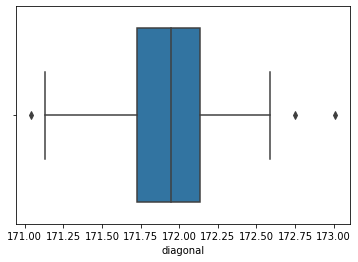

In [4]:
sns.boxplot(x=data.diagonal)

Il y a des outliers qui sont des valeurs aberrantes et qu'il faut supprimer.

In [5]:
Q1 = data['diagonal'].quantile(0.25)
Q3 = data['diagonal'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (data['diagonal'] >= Q1 - 1.5 * IQR) & (data['diagonal'] <= Q3 + 1.5 *IQR)
data = data.loc[filter]  

**Variable  'height_left'**

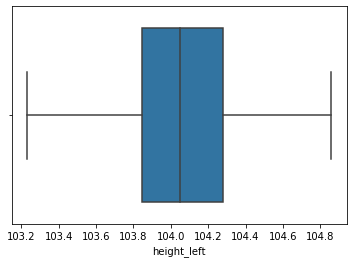

In [6]:
sns.boxplot(x=data.height_left)

Pas d'outliers

**Variable  'height_right'**

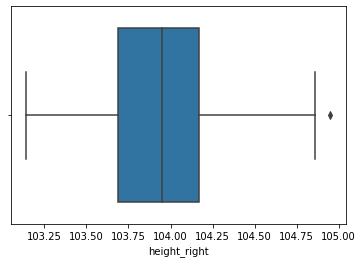

In [7]:
sns.boxplot(x=data.height_right)

Il y a des outliers qui sont des valeurs aberrantes et qu'il faut supprimer.

In [8]:
Q1 = data['height_right'].quantile(0.25)
Q3 = data['height_right'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (data['height_right'] >= Q1 - 1.5 * IQR) & (data['height_right'] <= Q3 + 1.5 *IQR)
data = data.loc[filter]  

**Variable  'margin_low'**

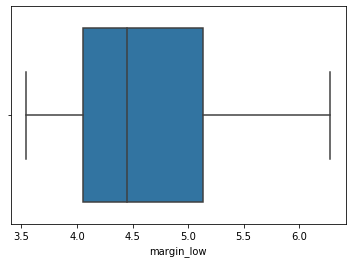

In [9]:
sns.boxplot(x=data.margin_low)

Pas d'outliers

**Variable  'margin_up'**

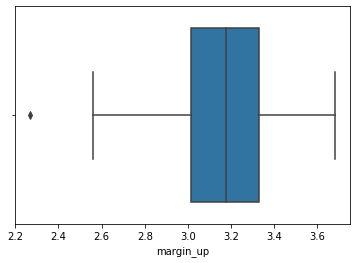

In [10]:
sns.boxplot(x=data.margin_up)

Il y a des outliers qui sont des valeurs aberrantes et qu'il faut supprimer.

In [11]:
Q1 = data['margin_up'].quantile(0.25)
Q3 = data['margin_up'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (data['margin_up'] >= Q1 - 1.5 * IQR) & (data['margin_up'] <= Q3 + 1.5 *IQR)
data = data.loc[filter]  

**Variable  'length'**

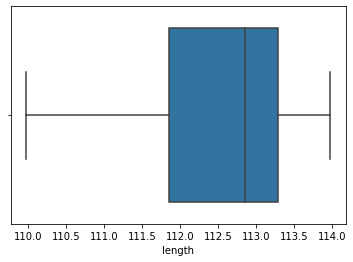

In [12]:
sns.boxplot(x=data.length)

Pas d'outliers

<a id="Intro_3"></a>
### <span style="color: #a40334">Pertinence des données</span>

Il y a 165 billets, dont 69 qui sont faux.


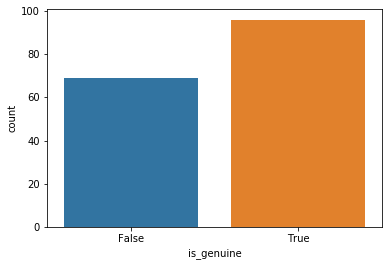

In [13]:
sns.countplot(x='is_genuine',data=data)

dataFalse = data[data.is_genuine==False]

print("Il y a",len(data),"billets, dont",len(dataFalse), "qui sont faux.")

L'analyse se base sur une majorité de vrais billets, ce qui permet d'obtenir des résultats cohérents.

<a id="chapitre_0"></a>
## <span style="color: #030aa4">Mission 0</span>

<a id="chapitre_0_1"></a>
### <span style="color: #a40334">Comparaison des écart-types</span>

In [14]:
data.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,171.934788,104.060364,103.922182,4.611515,3.177333,112.568848
std,0.283232,0.290726,0.323860,0.710143,0.227564,0.925008
min,171.130000,103.230000,103.140000,3.540000,2.560000,109.970000
25%,171.730000,103.850000,103.690000,4.050000,3.020000,111.850000
50%,171.940000,104.050000,103.950000,4.450000,3.180000,112.850000
75%,172.130000,104.280000,104.170000,5.140000,3.330000,113.290000
max,172.590000,104.720000,104.860000,6.280000,3.680000,113.980000


Hormis les variables 'margin_low' et 'length', toutes les variables ont un écart-type du même ordre de grandeur et relativement faible. Ces variables différent très peu de leur moyenne et ne semblent donc pas permettre de différencier un vrai d'un faux billet.

**L'écart-type de la variable 'length' est la plus élevée (0,925).**

<a id="chapitre_0_2"></a>
### <span style="color: #a40334">Indicateurs de tendance centrale et de dispersion</span>

In [15]:
dataQuantitative = data.drop(columns= 'is_genuine')

for x in dataQuantitative.columns :
    print("-"*20)
    print("Variable",x)
    print(" ")
    print("moy:\n",dataQuantitative[x].mean())
    print("med:\n",dataQuantitative[x].median())
    print("mod:\n",dataQuantitative[x].mode()[0])

--------------------
Variable diagonal
 
moy:
 171.9347878787879
med:
 171.94
mod:
 172.1
--------------------
Variable height_left
 
moy:
 104.06036363636359
med:
 104.05
mod:
 104.17
--------------------
Variable height_right
 
moy:
 103.92218181818184
med:
 103.95
mod:
 103.76
--------------------
Variable margin_low
 
moy:
 4.611515151515151
med:
 4.45
mod:
 3.97
--------------------
Variable margin_up
 
moy:
 3.1773333333333356
med:
 3.18
mod:
 3.07
--------------------
Variable length
 
moy:
 112.56884848484847
med:
 112.85
mod:
 113.38


À part 'margin_low' et 'length', toutes les variables ont une moyenne, une médiane et un mode approximativement égaux. Elles suivent donc une distribution normale.

**Seules les variables 'margin_low' et 'length' ne suivent pas une distribution normale. Ces deux variables pourraient donc différer selon le caractère véritable du billet.**

<a id="chapitre_0_3"></a>
### <span style="color: #a40334">Distribution des variables 'length' et 'margin_low'</span>

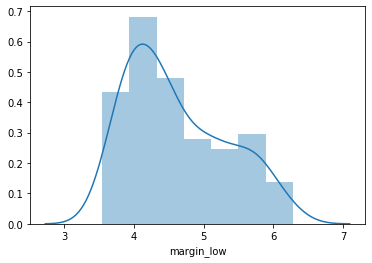

In [16]:
ax=sns.distplot(data['margin_low'])

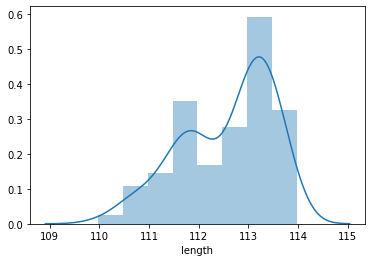

In [17]:
ax=sns.distplot(data['length'])

**Tandis que la variable 'margin_low' suit une distribution en forme de cloche avec une valeur modale bien supérieure, la variable 'length' affiche deux pics dans sa distribution.**

<a id="chapitre_0_4"></a>
### <span style="color: #a40334">Analyses bivariées</span>

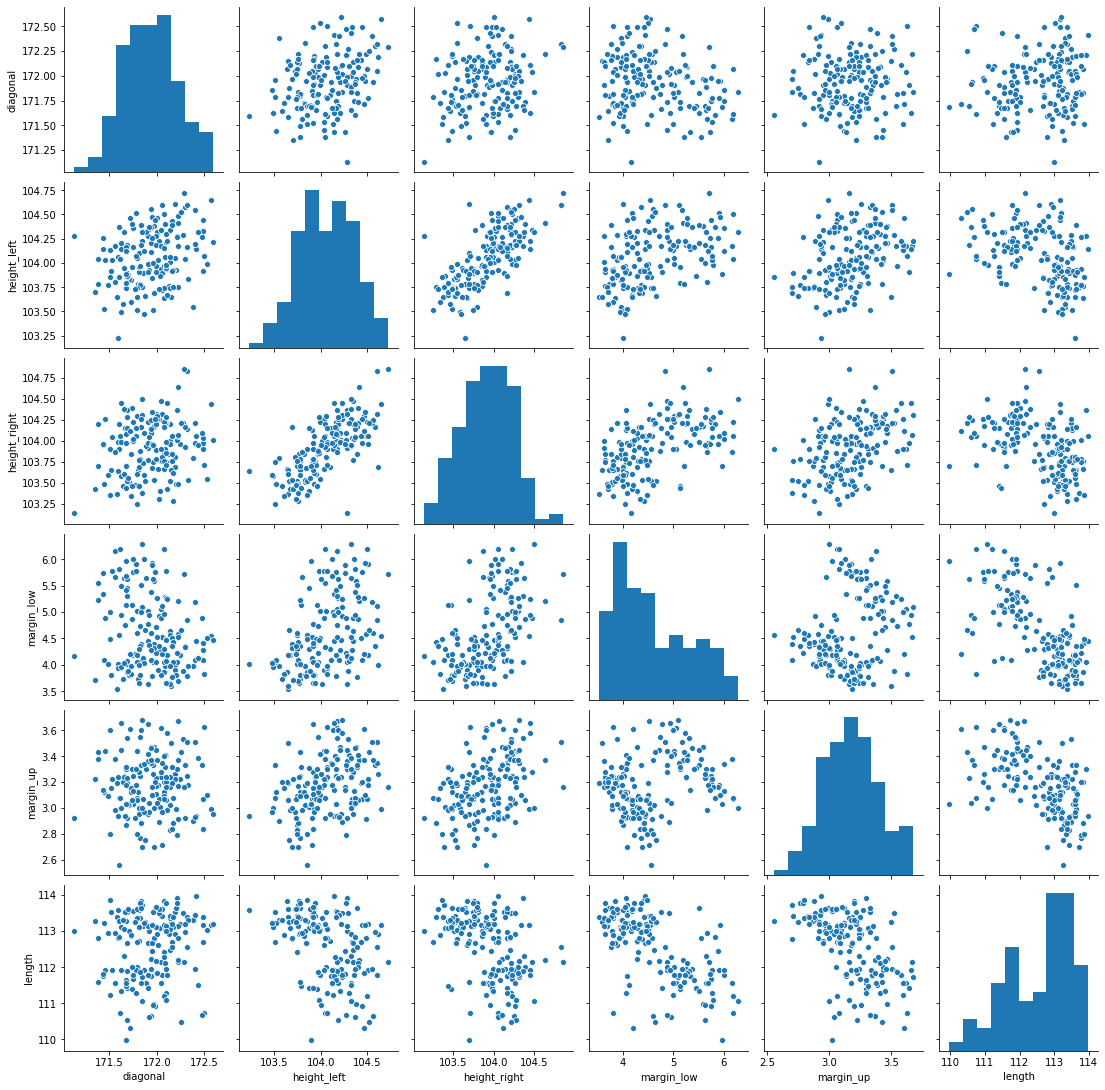

In [18]:
sns.pairplot(dataQuantitative)

On observe une corrélation entre les variables 'height_right' et 'height_left', ce qui est logique puisque les billets sont rectangulaires.

Cependant, dans cette même logique, nous devrions également observer une corrélation entre les variables 'diagonal' et 'length', ce qui n'est pas le cas.

<a id="chapitre_1"></a>
## <span style="color: #030aa4">Mission 1</span>

<a id="chapitre_1_1"></a>
### <span style="color: #a40334">Analyse de l'éboulis des valeurs propres</span>

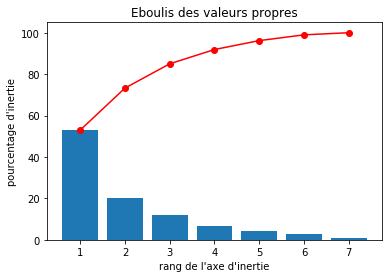

In [19]:
X = data.values

# Centrage et standardization
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Choix du nombre de composantes à calculer
n_comp = 7

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c='red',marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    
display_scree_plot(pca)

**Selon le critère de Kaiser, on ne retient que les deux premiers axes d'inertie.**

<a id="chapitre_1_2"></a>
### <span style="color: #a40334">Représentation des variables par le cercle des corrélations</span>

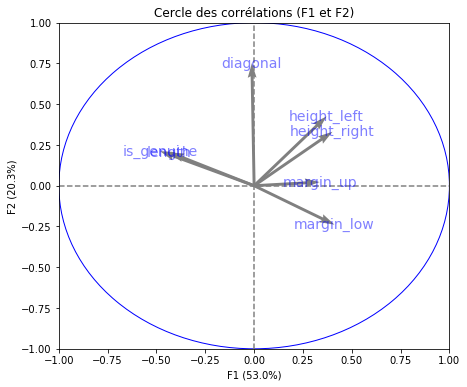

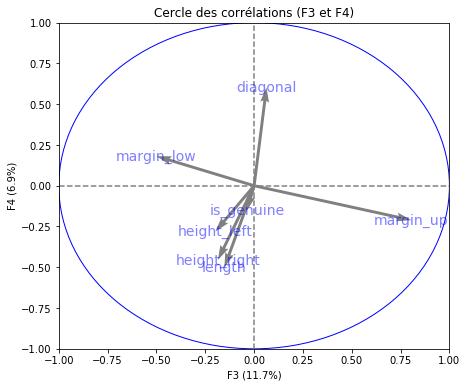

In [20]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            #plt.savefig("Cercle des corrélations.png")
            plt.show(block=False)
        

    
# choix du nombre de composantes à calculer
n_comp = 7

# sélection des colonnes à prendre en compte dans l'ACP
data_pca = data[['is_genuine',
                 'diagonal',
                 'height_left',
                 'height_right',
                 'margin_low',
                'margin_up',
                 'length']]

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean())

X = data_pca.values
names = data.index
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

Du premier cercle de corrélation, on déduit que :
- F1 est anticorrélé à 'length' et 'is_genuine'
- **'length' et 'is_genuine' sont parfaitement corrélées**
- F2 est parfaitement corrélé à 'diagonal'

Du deuxième cercle des corrélations, on déduit que :
- **'margin_low' et 'is_genuine' ne sont pas corrélées (cos=0)**

**Les billets dont la valeur de F1 est négative sont donc vrais.**

<a id="chapitre_1_3"></a>
### <span style="color: #a40334">Représentation des individus par le plan factoriel</span>

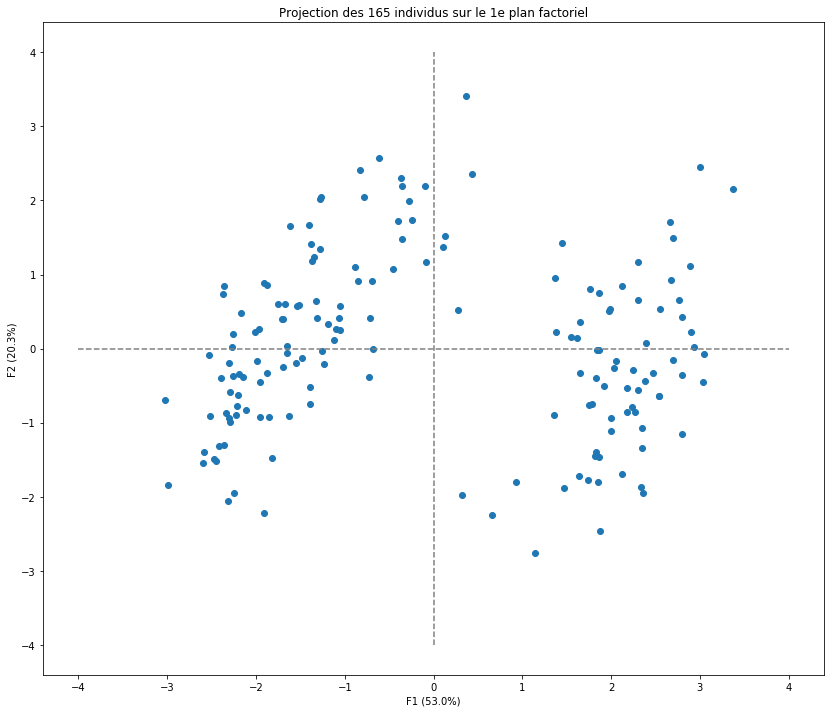

In [21]:
d1 = 0
d2 = 1

# Coordonnées F1, F2 de chaque point 

X_scaled = preprocessing.StandardScaler().fit_transform(data.values)
pca = decomposition.PCA(n_components=2)
X_projected = pca.fit_transform(X_scaled)
dataCP= pd.DataFrame(X_projected, index=data.index, columns = ["F"+str(i+1) for i in range(2)])

# Nuage de points :

fig = plt.figure(figsize=(14,12))
scatter = plt.scatter(dataCP['F1'], dataCP['F2'])

# Affichage des axes
plt.plot([-4, 4], [0, 0], color = 'grey', ls='--')
plt.plot([0, 0], [-4, 4] , color = 'grey', ls='--')

# Nom des axes
plt.xlabel("F{} ({}%)".format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel("F{} ({}%)".format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
#plt.legend(handles = scatter.legend_elements()[0], labels = classes)
#plt.savefig("Projection des 165 individus sur le 1er plan factoriel, méthode dendrogramme")
plt.show(block=False)

Le nuage de points semble se diviser en deux clusters séparés par une droite d'équation F1=F2.

<a id="chapitre_2"></a>
## <span style="color: #030aa4">Mission 2</span>

<a id="chapitre_2_1"></a>
### <span style="color: #a40334">Détermination du nombre de clusters</span>

Nous utilisons le coefficient de la silhouette pour déterminer le nombre de clusters.

In [22]:
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.5553496343887335
For n_clusters=3, The Silhouette Coefficient is 0.4177106109957249
For n_clusters=4, The Silhouette Coefficient is 0.22965806111033218
For n_clusters=5, The Silhouette Coefficient is 0.24865358700704776
For n_clusters=6, The Silhouette Coefficient is 0.26460470787455614
For n_clusters=7, The Silhouette Coefficient is 0.22352617358295357
For n_clusters=8, The Silhouette Coefficient is 0.24876406448708147
For n_clusters=9, The Silhouette Coefficient is 0.23122917840254065
For n_clusters=10, The Silhouette Coefficient is 0.2158450513952235


Le partitionnement en deux clusters est optimal. C'est pour ce nombre que le coefficient de la silouhette est le plus élevé.

<a id="chapitre_2_2"></a>
### <span style="color: #a40334">Répartition des données en 2 clusters (algorithme de la classification hiérarchique)</span>

In [23]:
# préparation des données pour le clustering
X = data.values
names = data.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

clusters = fcluster(Z, 2, criterion='maxclust')

dataClusters = pd.DataFrame({"cluster": clusters})

dataClusters.head(3)

,cluster
0,2
1,2
2,2


<a id="chapitre_2_3"></a>
### <span style="color: #a40334">Coordonnées des centroïdes de chaque cluster</span>

In [24]:
X_scaled = preprocessing.StandardScaler().fit_transform(data.values)
pca = decomposition.PCA(n_components=2)
X_projected = pca.fit_transform(X_scaled)
dataCP= pd.DataFrame(X_projected, index=data.index, columns = ["F"+str(i+1) for i in range(2)])

dataParCluster = dataClusters.join(dataCP)

dataParCluster.groupby('cluster').mean()

,F1,F2
cluster,,
1,1.914464,-0.358074
2,-1.527343,0.268515


**Le cluster 2 a une moyenne de F1 négative. C'est le cluster des vrais billets.**

<a id="chapitre_2_4"></a>
### <span style="color: #a40334">Nombre de billets par cluster et proportion de vrais billets</span>

In [25]:
dataProp = data.join(dataParCluster)

def prop_is_genuine(x):
    if x == True :
        return 1
    else :
        return 0
    
dataProp['prop_is_genuine']=data['is_genuine'].apply(lambda x: prop_is_genuine(x))
dataProp['nombre_de_billets']=1

dataProp = dataProp.loc[:,('cluster','nombre_de_billets','prop_is_genuine')]\
                   .groupby('cluster').sum()\
                   .reset_index()

dataProp['prop_is_genuine']/= dataProp['nombre_de_billets']
dataProp['prop_is_genuine']*=100
dataProp['prop_is_genuine'] = round(dataProp['prop_is_genuine'],2)

dataProp

,cluster,nombre_de_billets,prop_is_genuine
0,1.0,69,5.8
1,2.0,92,100.0


**100% des billets du cluster 2 sont vrais contre seulement 5,8% pour le cluster 1.**

<a id="chapitre_2_5"></a>
### <span style="color: #a40334">Application de l'algorithme de classification hiérarchique</span>

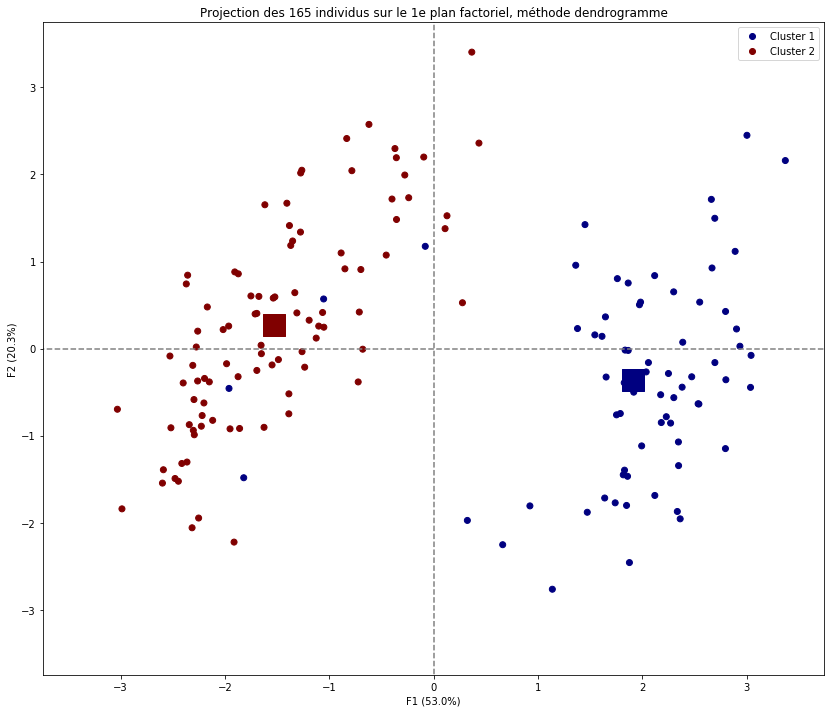

In [26]:
d1 = 0
d2 = 1

# Coordonnées F1, F2 de chaque point calculées dans dataframe 'dataParCluster'

# Coordonnées F1, F2 de chaque centroïde calculées depuis le coupage en deux clusters :

centroids = dataParCluster.groupby('cluster').mean()\
                                       .reset_index()

fig = plt.figure(figsize=(14,12))
cluster_values = list(dataClusters.cluster)
classes = list(np.unique(dataClusters.cluster))
classes = ['Cluster ' + str(x) for x in classes]
centroid_cluster_values = list(centroids.cluster)

# Nuage de points :

scatter = plt.scatter(dataParCluster['F1'], dataParCluster['F2'], c=cluster_values, cmap = 'jet')

# Superposition des centroïdes :

centroid_scatter = plt.scatter(centroids['F1'],
                               centroids['F2'],
                               marker = 's',
                               c = centroid_cluster_values,
                               cmap = 'jet',
                               s = 500)

boundary = np.max(np.abs(X_projected[:, [0,1]])) * 1.1
plt.xlim([-boundary,boundary])
plt.ylim([-boundary,boundary])

# Affichage des axes
plt.plot([-100, 100], [0, 0], color = 'grey', ls='--')
plt.plot([0, 0], [-100, 100] , color = 'grey', ls='--')

# Nom des axes
plt.xlabel("F{} ({}%)".format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel("F{} ({}%)".format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

plt.title("Projection des {} individus sur le 1e plan factoriel, méthode dendrogramme".format(X_projected.shape[0]))
plt.legend(handles = scatter.legend_elements()[0], labels = classes)
plt.show(block=False)

Le cluster 2 regroupe les vrais billets et le cluster 1 les faux billets.

<a id="chapitre_3"></a>
## <span style="color: #030aa4">Mission 3</span>

<a id="chapitre_3_1"></a>
### <span style="color: #a40334">Modélisation des données à l'aide d'une régression logistique</span>

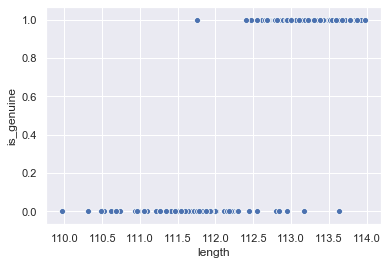

In [27]:
sns.set()

ax = sns.scatterplot(x="length", y="is_genuine", data=data)

#### Proportion de vrais billets selon les classes de longueur

In [28]:
# Conversion des données de la colonne "is_genuine" True et False en 1 et 0 :
data["is_genuine"] = data["is_genuine"].view('i1')

In [29]:
data['cl_length'] = pd.cut(data['length'], bins = np.arange(110, 114, 0.5), right=False)
prop = pd.crosstab(data['cl_length'], data['is_genuine'], normalize='index')
prop_genuine = pd.DataFrame(data = {'length': np.concatenate((np.array([110]), 
                                                       np.repeat(np.arange(110.5,113.5,0.5), repeats=2), 
                                                       np.array([113.5])), axis=0),
                                'prop_genuine': np.repeat(prop.loc[:,1].values, repeats=2)})

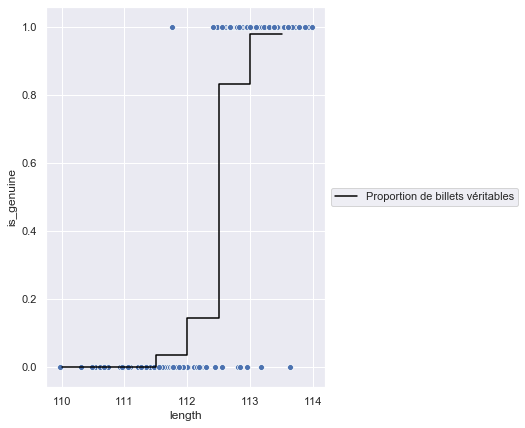

In [30]:
plt.figure(figsize=(5,7))
ax = sns.scatterplot(x="length", y="is_genuine", data=data)
plt.plot(prop_genuine['length'], prop_genuine['prop_genuine'], color='black', label='Proportion de billets véritables')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Régression logistique

In [31]:
reg_log1 = smf.glm('is_genuine ~ length', data=data, family=sm.families.Binomial()).fit()

print(reg_log1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                  165
Model:                            GLM   Df Residuals:                      163
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -31.285
Date:                Thu, 20 Aug 2020   Deviance:                       62.570
Time:                        17:34:33   Pearson chi2:                     339.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -542.9444     86.699     -6.262      0.0

On obtient les paramètres estimés : $\hat{\beta}_{1}=−549.07$ et $\hat{\beta}_{2}=4.88$. Enregistrons-les :

In [32]:
beta1 = reg_log1.params[0]
beta2 = reg_log1.params[1]

Dans le but de tracer la courbe logistique entre les abscisses $x=110$ et $x=114$, on définit une séquence de 110 à 114 par pas de 500, puis on la place dans la variable x. On calcule ensuite les ordonnées de la courbe, grâce à l'expression de la courbe en S :
<br><br><center><font size="4">$f(x) = \frac{e^{\beta_{1}+\beta_{2}x}}{1+e^{\beta_{1}+\beta_{2}x}}$</font></center>

Nous plaçons ces ordonnées dans la variable y. Enfin, avec x et y, nous créons un dataframe :

In [33]:
x = np.linspace(start=110, stop=114, num=500)
y = np.exp(beta1+beta2*x)/(1+np.exp(beta1+beta2*x))
reg_log = pd.DataFrame(data={'length': x, 'prop_genuine': y})

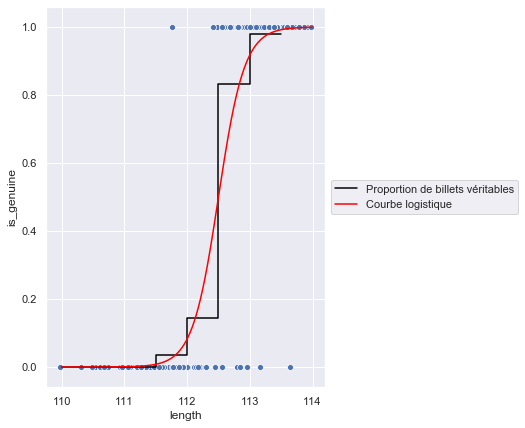

In [34]:
plt.figure(figsize=(5,7))
ax = sns.scatterplot(x="length", y="is_genuine", data=data)
plt.plot(prop_genuine['length'], prop_genuine['prop_genuine'], color='black', label='Proportion de billets véritables')
plt.plot(reg_log['length'], reg_log['prop_genuine'], color='red', label='Courbe logistique')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()